In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os 
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.basicConfig(level = logging.INFO)
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     logging.info(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    logging.info(e)

In [11]:
training_data = np.load("../../Data/n1000000_0910_all_flat.npz")
data_all = np.column_stack([training_data['ve_dune'][:,:36], training_data['vu_dune'][:,:36], training_data['vebar_dune'][:,:36], training_data['vubar_dune'][:,:36]])

# theta13, theta23, delta
target = np.column_stack([training_data["theta13"]/180*np.pi, training_data["theta23"]/180*np.pi,
                         np.cos(training_data["delta"]/180*np.pi), np.sin(training_data["delta"]/180*np.pi)])


split = 900000
x_train = data_all[:split]
y_train = target[:split]
x_train_poisson = np.random.poisson(x_train)/1000

x_val = data_all[split:]
y_val = target[split:]
x_val_poisson = np.random.poisson(x_val)/1000

In [19]:
def create_dnn_model():
    inputs = tf.keras.Input(shape=(len(x_train[0]),), name = 'input')
    features = tf.keras.layers.BatchNormalization()(inputs)
    features = tf.keras.layers.Dense(1024, activation='relu')(features)
    features = tf.keras.layers.Dense(1024, activation='relu')(features)
    features = tf.keras.layers.Dense(1024, activation='relu')(features)
    features = tf.keras.layers.Dense(1024, activation='relu')(features)
    features = tf.keras.layers.Dense(1024, activation='relu')(features)
    features = tf.keras.layers.Dense(1024, activation='relu')(features)
    features = tf.keras.layers.Dense(2, activation='linear')(features)
    outputs = features
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [20]:
dnn = create_dnn_model()
dnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()],
)

In [21]:
dnn.fit(x_train, y_train[:,2:],
           validation_data = (x_val, y_val[:,2:]),
           batch_size=1024,
           epochs=5,
           verbose=1,
           shuffle = True
         )

Epoch 1/5
879/879 [==============================] - 4s 4ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 2/5
879/879 [==============================] - 4s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 3/5
879/879 [==============================] - 4s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 3.5409e-04 - val_mean_squared_error: 3.5409e-04
Epoch 4/5
879/879 [==============================] - 4s 4ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 5/5
879/879 [==============================] - 4s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 5.2459e-04 - val_mean_squared_error: 5.2459e-04


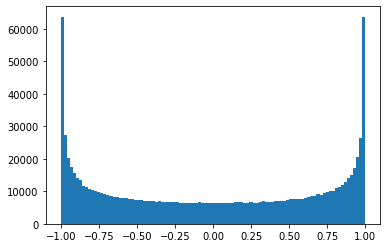

In [18]:
plt.hist(target[:, 3], bins=100)
plt.show()

In [7]:
data = np.load('../../Data/sample_NuFit0911.npz')
data_all = np.column_stack([data['ve_dune'][:,:36], data['vu_dune'][:,:36], data['vebar_dune'][:,:36], data['vubar_dune'][:,:36]])

In [10]:
dnn.predict(data_all[:1, :])

array([[3.3676476]], dtype=float32)

In [ ]:
index = 1
while os.path.isfile('/home/ML4NO/ML_DUNE/Regression/models/0910_2params_{}.h5'.format(index)):
    index += 1
model.save('/home/ML4NO/ML_DUNE/Regression/models/0910_2params_{}.h5'.format(index))

In [ ]:
scale_steps = np.logspace(-3, 0, 100)
before_train_loss = []
after_train_loss = []

for scale in scale_steps:
    x_train2_gen = np.random.normal(x_train2, np.sqrt(x_train2)*scale)
    x_test_gen = np.random.normal(x_test, np.sqrt(x_test)*scale)

    before_train_loss.append(model.evaluate(x_test_gen, y_test)[0])

    model.fit(x_train2_gen, y_train2,
               validation_split = 0.1,
               batch_size=64,
               epochs=5,
               verbose=1,
               shuffle = True
             )

    after_train_loss.append(model.evaluate(x_test_gen, y_test)[0])

In [ ]:
model_index = index
index = 1
path = '/home/ML4NO/ML_DUNE/Regression/models_furthurTrain/0910_2params_{}_{}.h5'
while os.path.isfile(path.format(model_index, index)):
    index += 1
model.save(path.format(model_index, index))
outfile = {'scale_steps': scale_steps,
           'before_train_loss': before_train_loss,
           'after_train_loss' :after_train_loss}
np.save(file = '/home/ML4NO/ML_DUNE/Regression/models_furthurTrain/0910_2params_{}_{}_result.npy'.format(model_index, index),
        arr = outfile)

In [ ]:
x_test2_gen = np.random.poisson(x_test)

for i in range(20):
    x_train2_gen = np.random.poisson(x_train2)
    
    model.fit(x_train2_gen, y_train2,
              validation_split=0.1,
               batch_size=64,
               epochs=1,
               verbose=1,
               shuffle = True
             )
model.evaluate(x_test2_gen, y_test)

In [ ]:
furthur_index = index
index = 1
path = '/home/ML4NO/ML_DUNE/Regression/models_PoissonTrain/0910_2params_{}_{}_{}.h5'
while os.path.isfile(path.format(model_index, furthur_index, index)):
    index += 1
model.save(path.format(model_index, furthur_index, index))